# GoogLeNet

- 2014 ILSVRC 1nd place 
- Inception Module

![대체 텍스트](https://cdn-images-1.medium.com/max/2560/1*ZFPOSAted10TPd3hBQU8iQ.png)

## 1.학습전 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.10.0+cu128


## 2.하이퍼파라미터 설정

In [2]:
batch_size= 10
learning_rate = 0.0002
num_epoch = 100

## 3.데이터 로더

In [17]:
# 입력 분포를 일정하게 맞춰서 학습을 안정하게 해줍니다.
# 채널마다 밝기/대비 스케일 차이를 보정 해줍니다.
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616) 

# GoogLeNet 입력 스펙 (224x224)기준 단, CIFAR-10(32x32)이므로 성능이 흔들릴 수 있기에 나중에 성능이 안 나오면 조정하시면 됩니다.
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224), # 랜덤하게 224x224 크기로 자릅니다.
    transforms.RandomHorizontalFlip(), # 랜덤하게 이미지를 좌우로 뒤집습니다.
    transforms.ToTensor(), # 이미지를 텐서로 변환합니다.
    transforms.Normalize(mean, std),
])
# train_tf는 학습데이터이기에 Resize 대신 RandomResizedCrop을 사용하여 랜덤하게 자름.
# val_tf는 검증데이터이기에 Resize와 CenterCrop을 사용하여 일정하게 자름.

val_tf = transforms.Compose([
    transforms.Resize(256), # 이미지를 256x256 크기로 조정합니다.
    transforms.CenterCrop(224), # 중앙에서 224x224 크기로 자릅니다.
    transforms.ToTensor(), # 이미지를 텐서로 변환합니다.
    transforms.Normalize(mean, std),

])

train_set = dset.CIFAR10(root="./data", train=True, transform=train_tf, download=True)
val_set   = dset.CIFAR10(root="./data", train=False, transform=val_tf, download=True)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

### 

## 4.모델정의

### 4.1 Inception 모듈 정의
- 인셉션 모듈을 구성하는 4가지 연산을 함수로 정의해놓습니다.
- 1x1 컨볼루션
- 1x1 컨볼루션 -> 3x3 컨볼루션
- 1x1 컨볼루션 -> 5x5 컨볼루션
- 3x3 맥스풀링 ->1x1 컨볼루션

![대체 텍스트](https://blog.kakaocdn.net/dna/bTVYaJ/btrwdltxtrg/AAAAAAAAAAAAAAAAAAAAAO3mZ2xtjrAh6_CAZnqjaRxxEDSIjPrlnyvA95lygeAN/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1772290799&allow_ip=&allow_referer=&signature=nYD3d6swoB6RYojtU0ezytYwOZQ%3D)

In [4]:
# GoogLeNet의 Inception은 병렬 경로가 핵심이므로 branch라는 표현으로 작성 시작하겠습니다.
# layer는 보통 순차 블록 느낌이 강해서 병렬 구조를 덜 명확하게 표현할 수 있습니다.
# conv는 합성곱 하나를 떠올리게 해서 Conv+ReLU(+Pool) 묶음을 의미하여 Inception과 맞지 않습니다.

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()

        # 1x1 branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
        )

        # 1x1 -> 3x3 branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

        # 1x1 -> 5x5 branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2, bias=False),
            nn.ReLU(inplace=True),
        )

        # 3x3 max pool -> 1x1 branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        # 각 브렌치 출력합니다.
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], dim=1)

### InceptionAux
- 깊어진 모델의 gradient vanishing 문제를 막기 위해 나온 개념입니다.
- 그래서 layer 중간에 auxiliary classifier가 위치하여 중간 위치의 정보를 잃지 않고 추가적으로 역전파를 일으키는 역할을 합니다.

![대체텍스트](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2Fcw82np%2FbtsGOwDdTyE%2FAAAAAAAAAAAAAAAAAAAAAKPnpp0vRcwpDAWGq1k7BPIsm2Q5w6MxHKBH6aEPtRgO%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1772290799%26allow_ip%3D%26allow_referer%3D%26signature%3DSudswOr%252FLQD0ODjO3NdVuyP1MCM%253D)

In [5]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            nn.Conv2d(in_channels, 128, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4)) # 4x4 크기로 출력하도록 조정합니다.
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 1024), # 128채널의 4x4 피쳐맵이 입력입니다.
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(1024, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # 배치 차원은 유지하고 나머지는 평탄화합니다.
        return self.classifier(x)

### 4.2 GoogLeNet 정의
![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*CWJGqfLiVjHAIan82nPbjg.png)

In [6]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=True):
        super().__init__()
        self.aux_logits = aux_logits
        
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False), # 224 -> 112 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # 112 -> 56
            nn.Conv2d(64, 64, kernel_size=1, bias=False), # 56 -> 56
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False), # 56 -> 56
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # 56 -> 28
        )

        self.stage3 = nn.Sequential(
            Inception(192, 64, 96, 128, 16, 32, 32), # Inception 3a , out: 256 x 28 x 28
            Inception(256, 128, 128, 192, 32, 96, 64), # Inception 3b , out: 480 x 28 x 28
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # 480 x 14 x 14
        )

        self.in4a = Inception(480, 192, 96, 208, 16, 48, 64)                    # out: 512 x 14 x 14
        self.in4b = Inception(512, 160, 112, 224, 24, 64, 64)                   # out: 512 x 14 x 14
        self.in4c = Inception(512, 128, 128, 256, 24, 64, 64)                   # out: 512 x 14 x 14
        self.in4d = Inception(512, 112, 144, 288, 32, 64, 64)                   # out: 528 x 14 x 14
        self.in4e = Inception(528, 256, 160, 320, 32, 128, 128)                 # out: 832 x 14 x 14
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes) # 4a에서 분기
            self.aux2 = InceptionAux(528, num_classes) # 4d에서 분기
        
        self.stage5 = nn.Sequential(
            Inception(832, 256, 160, 320, 32, 128, 128), # Inception 5a, out: 832 x 7 x 7
            Inception(832, 384, 192, 384, 48, 128, 128), # Inception 5b, out: 1024 x 7 x 7
            nn.AdaptiveAvgPool2d((1,1)), # (1x1)로 만듭니다. out: 1024 x 1 x 1
        )
        
        # classifier head
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.stage3(x)
        x = self.in4a(x)
        aux1 = self.aux1(x) if self.training and self.aux_logits else None

        x = self.in4b(x)
        x = self.in4c(x)
        x = self.in4d(x)
        aux2 = self.aux2(x) if self.training and self.aux_logits else None

        x = self.in4e(x)
        x = self.maxpool4(x)

        x = self.stage5(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.training and self.aux_logits:
            return x, aux2, aux1
        return x

## 5.손실함수 최적화 정의

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = GoogLeNet(num_classes=10, aux_logits=True).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)


cuda:0


## 6. 모델 파라미터

In [9]:
!pip install torchinfo
!pip install torchview

In [12]:
# 방법 1: 시각화/요약할 때만 aux 끄기
model = GoogLeNet(num_classes=10, aux_logits=False).to(device)
summary(model, input_size=(1, 3, 224, 224))



Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [1, 10]                   --
├─Sequential: 1-1                        [1, 192, 28, 28]          --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─ReLU: 2-2                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-3                    [1, 64, 56, 56]           --
│    └─Conv2d: 2-4                       [1, 64, 56, 56]           4,096
│    └─ReLU: 2-5                         [1, 64, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 192, 56, 56]          110,592
│    └─ReLU: 2-7                         [1, 192, 56, 56]          --
│    └─MaxPool2d: 2-8                    [1, 192, 28, 28]          --
├─Sequential: 1-2                        [1, 480, 14, 14]          --
│    └─Inception: 2-9                    [1, 256, 28, 28]          --
│    │    └─Sequential: 3-1              [1, 64, 28, 28]           12,288


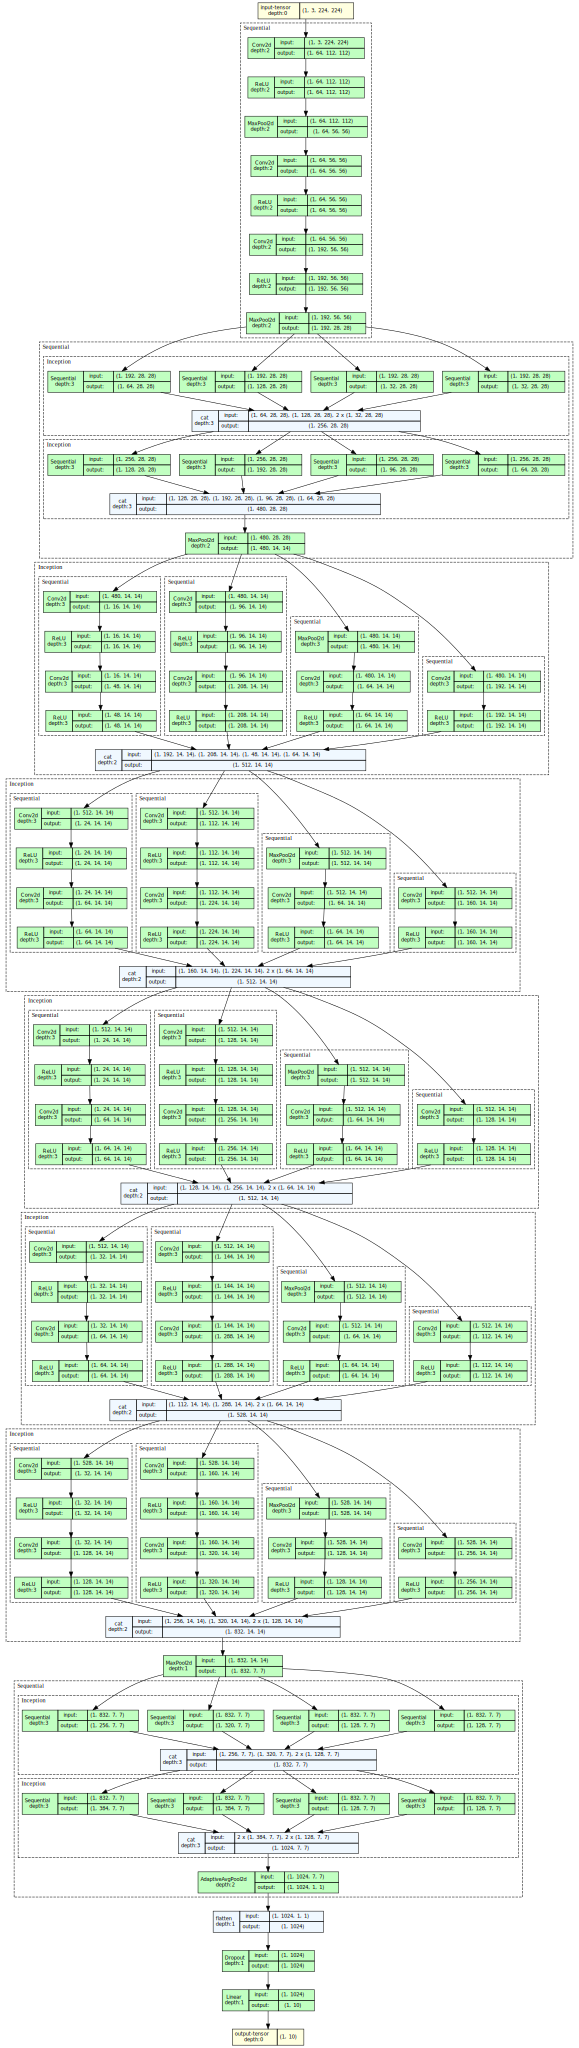

In [13]:
from torchview import draw_graph
g = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
g.visual_graph

## train

In [18]:
def train_one_epoch(model, loader, optimizer, loss_func, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        if model.aux_logits:
            main_logits, aux2_logits, aux1_logits = model(images)
            loss = (
                loss_func(main_logits, labels)
                + 0.3 * loss_func(aux1_logits, labels)
                + 0.3 * loss_func(aux2_logits, labels)
            )
            logits = main_logits
        else:
            logits = model(images)
            loss = loss_func(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


In [16]:
from torchvision import transforms

print("std var:", std, type(std))

# 현재 train_set에 박힌 Normalize 값 확인
norm = [t for t in train_set.transform.transforms if isinstance(t, transforms.Normalize)][0]
print("normalize mean:", norm.mean)
print("normalize std :", norm.std)


std var: (0.247, 0, 2435, 0.2616) <class 'tuple'>
normalize mean: (0.4914, 0.4822, 0.4465)
normalize std : (0.247, 0, 2435, 0.2616)


In [ ]:
train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_func, device)
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")